In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
import timm 

In [2]:
def load_data(dataname, quality):
    # data : "f2f_data", "nt_data"
    # quality : "high", "low"
    
    if quality == "high" :
        directory = "High Quality/"
        
    elif quality == "low":
        directory = "Low Quality/"
        
    else:
        return "filename exception"
    
    if dataname == "f2f_data" :
        directory += "f2f_data/"
        
    elif dataname == "nt_data" :
        directory += "nt_data/"
    else:
        return "filename exception"
    
    train_path = directory + "train/"
    test_path = directory + "test/"
    val_path = directory + "val/"
    
    # make a transform 
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    val_images = []
    val_labels = []
    
    # train load
    for filename in os.listdir(train_path):
        image_path = os.path.join(train_path, filename)
        if filename[:4] == "fake":
            label = 0  # 0 for fake
        else:
            label = 1  # 1 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        train_images.append(image_tensor)
        train_labels.append(label)

    # test load
    for filename in os.listdir(test_path):
        image_path = os.path.join(test_path, filename)
        if filename[:4] == "fake":
            label = 0  # 0 for fake
        else:
            label = 1  # 1 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        test_images.append(image_tensor)
        test_labels.append(label)

    # val load
    for filename in os.listdir(val_path):
        image_path = os.path.join(val_path, filename)
        if filename[:4] == "fake":
            label = 0  # 0 for fake
        else:
            label = 1  # 1 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        val_images.append(image_tensor)
        val_labels.append(label)
        
    train_images = torch.stack(train_images, dim=0)
    test_images = torch.stack(test_images, dim=0)
    val_images = torch.stack(val_images, dim=0)
    train_labels = torch.tensor(train_labels)
    test_labels = torch.tensor(test_labels)
    val_labels = torch.tensor(val_labels)
    
    train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
    test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
    val_dataset = torch.utils.data.TensorDataset(val_images, val_labels)
    
    return train_dataset, test_dataset, val_dataset


In [3]:
def train_val_model(pre_model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # list of loss, acc for plot
    train_loss_acc = []
    val_loss_acc = []
    
    # train
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # to gpu

            optimizer.zero_grad()
            outputs = model(inputs) # forward
            
            loss = criterion(outputs, labels) # calculate loss with loss function
            
            
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            
            loss.backward() # train -> backward to update weight
            optimizer.step()
            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
                
        # validation
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) # to gpu

                outputs = model(inputs) # forward
                loss = criterion(outputs, labels) # calculate loss with loss function
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_acc / len(val_loader.dataset)
        
        
        #print("Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}"
        #      .format(epoch + 1, num_epochs, train_loss, train_acc))
        #print("Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
        #      .format(epoch + 1, num_epochs, val_loss, val_acc))
        
        train_loss_acc.append((train_loss,train_acc))
        val_loss_acc.append((val_loss, val_acc))
        
    return train_loss_acc, val_loss_acc
    

In [4]:
from sklearn.metrics import f1_score, recall_score, precision_score
def eval_model(test_loader, criterion):
    test_loss_acc = []
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        y_true = []
        y_pred = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # to gpu

            outputs = model(inputs) # forward
            loss = criterion(outputs, labels) # calculate loss with loss function
                
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
            y_true.extend(labels.cpu().numpy()) # labels to cpu and to numpy array
            y_pred.extend(preds.cpu().numpy()) # preds to cpu and to numpy array

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_acc / len(test_loader.dataset)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        
        
    print("Test Loss: {:.4f}, Test Accuracy: {:.4f}, F1 Score: {:.4f}, Recall: {:.4f}, Precision: {:.4f}"
              .format(test_loss, test_acc, f1, recall, precision))
    
    test_loss_acc.append((test_loss,test_acc, f1, recall, precision))

    return test_loss_acc

In [5]:
import matplotlib.pyplot as plt

def plottv(train_loss_acc, val_loss_acc, num_epochs):
    x = range(1, num_epochs+1)
    tloss_y = []
    vloss_y = []
    tacc_y = []
    vacc_y = []
    for tloss, tacc in train_loss_acc:
        tloss_y.append(tloss)
        tacc_y.append(tacc.item())
        
    for vloss, vacc in val_loss_acc:
        vloss_y.append(vloss)
        vacc_y.append(vacc.item())
        
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(x, tloss_y, label="train")
    plt.plot(x, vloss_y, label="validation")
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot(x, tacc_y, label="train")
    plt.plot(x, vacc_y, label="validation")
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [6]:
def train(model, train_data, test_data, val_data):
    train_loader =  torch.utils.data.DataLoader(f2f_high_train, batch_size=32, shuffle=True)
    test_loader =  torch.utils.data.DataLoader(f2f_high_test, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(f2f_high_val, batch_size=32, shuffle=True)

    # criterion, optimizer, epochs
    criterion = nn.CrossEntropyLoss() # crossentropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer
    num_epochs = 100 # epochs

    train_loss_acc, val_loss_acc = train_val_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
    test_loss_acc = eval_model(test_loader, criterion)
    plottv(train_loss_acc, val_loss_acc, num_epochs)
    

In [7]:
# load all of data
# load_data return tuple of TensorDataset
f2f_high_train, f2f_high_test, f2f_high_val = load_data("f2f_data", "high")
f2f_low_train, f2f_low_test, f2f_low_val = load_data("f2f_data", "low")

nt_high_train, nt_high_test, nt_high_val = load_data("nt_data", "high")
nt_low_train, nt_low_test, nt_low_val = load_data("nt_data", "low")

In [8]:
device = 'cuda:0'

Face2Face HIGH EfficientnetB0

Test Loss: 0.1075, Test Accuracy: 0.9799, F1 Score: 0.9802, Recall: 0.9950, Precision: 0.9659


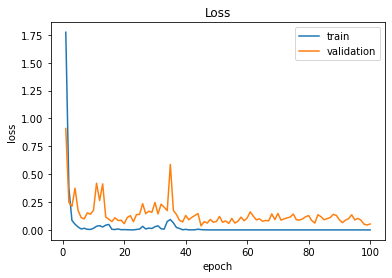

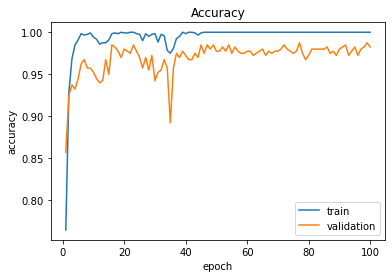

In [9]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device) 
train(model, f2f_high_train, f2f_high_test, f2f_high_val)

Face2Face HIGH Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.0449, Test Accuracy: 0.9799, F1 Score: 0.9799, Recall: 0.9799, Precision: 0.9799


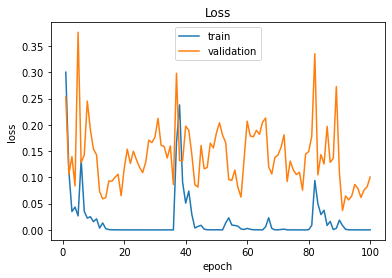

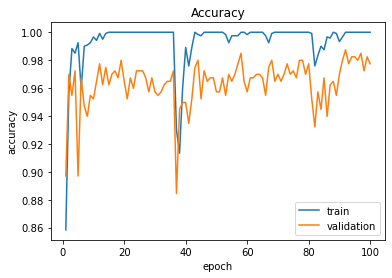

In [10]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, f2f_high_train, f2f_high_test, f2f_high_val)

Face2Face LOW EfficientnetB0

Test Loss: 0.2363, Test Accuracy: 0.9447, F1 Score: 0.9442, Recall: 0.9347, Precision: 0.9538


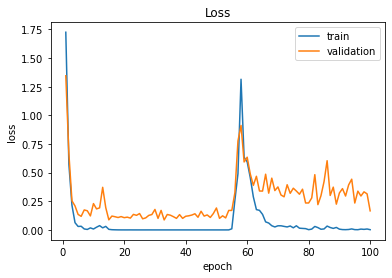

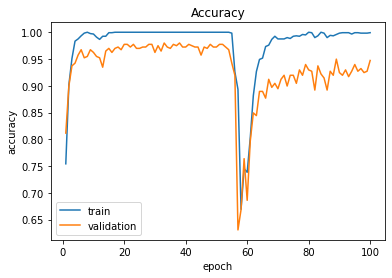

In [11]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, f2f_low_train, f2f_low_test, f2f_low_val)

Face2Face LOW Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.0849, Test Accuracy: 0.9774, F1 Score: 0.9771, Recall: 0.9648, Precision: 0.9897


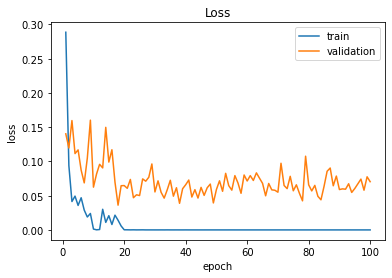

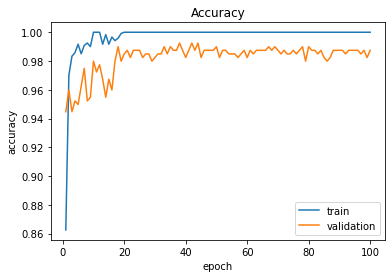

In [12]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, f2f_low_train, f2f_low_test, f2f_low_val)

NeuralTexture HIGH EfficientnetB0

Test Loss: 0.2646, Test Accuracy: 0.9372, F1 Score: 0.9364, Recall: 0.9246, Precision: 0.9485


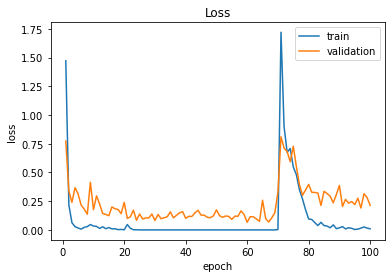

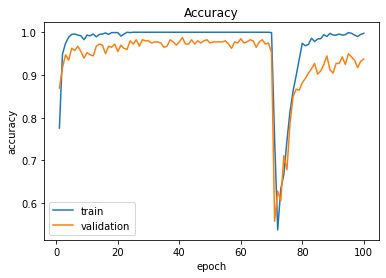

In [13]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, nt_high_train, nt_high_test, nt_high_val)

NeuralTexture HIGH Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.1821, Test Accuracy: 0.9548, F1 Score: 0.9550, Recall: 0.9598, Precision: 0.9502


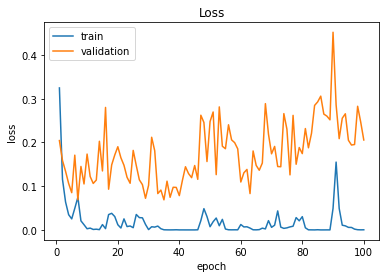

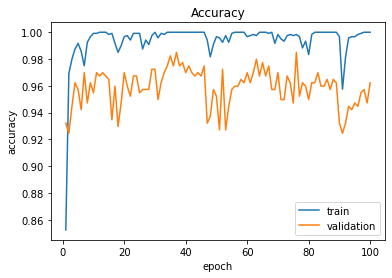

In [14]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, nt_high_train, nt_high_test, nt_high_val)

NeuralTexture LOW EfficientnetB0

Test Loss: 0.0626, Test Accuracy: 0.9849, F1 Score: 0.9850, Recall: 0.9899, Precision: 0.9801


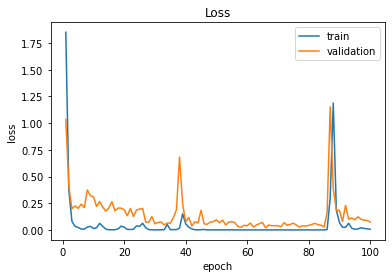

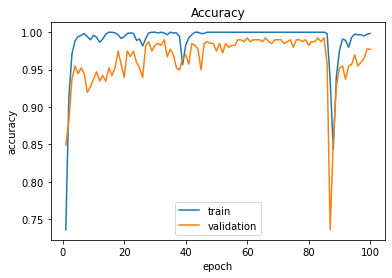

In [15]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, nt_low_train, nt_low_test, nt_low_val)

NeuralTexture LOW Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.0893, Test Accuracy: 0.9774, F1 Score: 0.9771, Recall: 0.9648, Precision: 0.9897


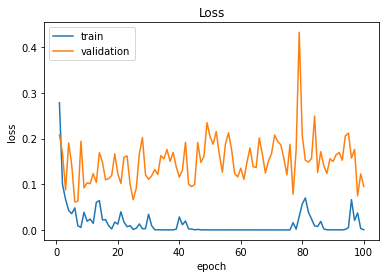

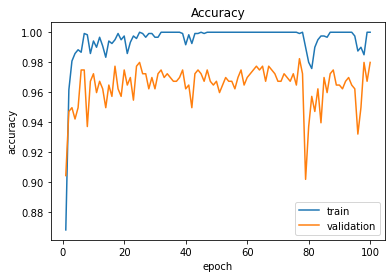

In [16]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, nt_low_train, nt_low_test, nt_low_val)